In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from  keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
import tensorflow as tf
import numpy as np
from numpy  import expand_dims
from matplotlib import pyplot as plt
import cv2
from keras.applications.vgg16 import VGG16

# 4. 개고양이 분류하기

In [5]:
batch_size = 16
image_size = 224

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
# 너무 많은 노이즈를 주면 인식률에 영향을 줌
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        'dataset/smallcatdog/train',  # this is the target directory
        target_size=(224, 224),  # 모든 이미지의 크기가 150x150로 조정됩니다.
        batch_size=batch_size,
        class_mode='binary')  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.

test_generator = test_datagen.flow_from_directory(
        'dataset/smallcatdog/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

# 두가지 클래스로 2000장, 800장

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


 ## 1)전이학습 : Freeze

In [9]:
#CNN은 특징 추출과 분류기로 이루어짐
#include_top을 false로 주면 특징 추출기까지만 구성된 weight를 가지게 된다.
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

vgg_conv.summary()

for layer in vgg_conv.layers[:]:
    layer.trainable = False # vgg 신경을 freeze해서 학습이 이루어지지 않도록 한다, 학습된 weight 사용

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

model = Sequential()

# 특징 추출을 VGG16으로 하겠다. 앞단을 vgg_conv
model.add(vgg_conv) # vgg신경망 구조를 사용하곘다

model.add(Flatten()) # 1차원으로 바꾸고
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
model.fit_generator(train_generator, epochs=1)

125/125 [==============================] - 151s 1s/step - loss: 0.9035 - accuracy: 0.7995


In [13]:
scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

accuracy: 85.87%


## 2)전이학습:Fine Tunning

In [14]:
# 전체적인 컨셉은 프리징과 비슷하다
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# 여기가 프리징과 다르다. 프리징은 사전학습모델 모든 레이어를 학습이 불가능하도록 false로 바꿨는데
# fine tunning은 마지막 층 4개를 제외하고 false로 만들어 마지막 4개는 재학습을 하도록 한다.
# 낮은 층에서 상위로 갈 수록 우리가 풀고자 하는 도메인에 비슷한 필터들이 학습
# 낮은 층은 우리가 풀고자하는 도메인과 관련성이 떨어지므로 false를 주어 학습을 하지 않지만
# 마지막 층은 우리가 풀고자 하는 도메인과 관련이 크기 때문에 재학습을 하도록 한다.
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

<keras.engine.input_layer.InputLayer object at 0x7fcc7088e940> False
<keras.layers.convolutional.Conv2D object at 0x7fcc7088eb50> False
<keras.layers.convolutional.Conv2D object at 0x7fcc708fb1f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc7088ea00> False
<keras.layers.convolutional.Conv2D object at 0x7fcc7089b7c0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc70825940> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc7088ef10> False
<keras.layers.convolutional.Conv2D object at 0x7fcc7081dbe0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc7089bd90> False
<keras.layers.convolutional.Conv2D object at 0x7fcc70836880> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc7081dc40> False
<keras.layers.convolutional.Conv2D object at 0x7fcc708363d0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc70840970> False
<keras.layers.convolutional.Conv2D object at 0x7fcc70844c70> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc7084bf40>

In [15]:
model.fit_generator(train_generator, epochs=1)

125/125 [==============================] - 183s 1s/step - loss: 0.8741 - accuracy: 0.5000


In [16]:
scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

accuracy: 50.00%


# 5. 음식분류

In [3]:
batch_size = 16

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/food-11/training',  #11개의 음식을 구분하도록 한 데이터셋들
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'dataset/food-11/evaluation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [5]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_conv.summary()

for layer in vgg_conv.layers[:]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

model = Sequential()

model.add(vgg_conv)

model.add(GlobalAveragePooling2D())                       
model.add(Dense(1024, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
history = model.fit_generator(train_generator, epochs=10)

/home/ssongkim/projects/study-opencv-ml/.venv/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-05 18:34:25.525769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
617/617 [==============================] - 704s 1s/step - loss: 1.3962 - accuracy: 0.5245
Epoch 2/10
617/617 [==============================] - 701s 1s/step - loss: 1.0838 - accuracy: 0.6314
Epoch 3/10
617/617 [==============================] - 706s 1s/step - loss: 1.0035 - accuracy: 0.6546
Epoch 4/10
617/617 [==============================] - 704s 1s/step - loss: 0.9362 - accuracy: 0.6805
Epoch 5/10
617/617 [==============================] - 707s 1s/step - loss: 0.9081 - accuracy: 0.6893
Epoch 6/10
617/617 [==============================] - 700s 1s/step - loss: 0.8703 - accuracy: 0.6961
Epoch 7/10
617/617 [==============================] - 700s 1s/step - loss: 0.8430 - accuracy: 0.7119
Epoch 8/10
617/617 [==============================] - 701s 1s/step - loss: 0.8098 - accuracy: 0.7203
Epoch 9/10
617/617 [==============================] - 707s 1s/step - loss: 0.7771 - accuracy: 0.7341
Epoch 10/10
617/617 [==============================] - 703s 1s/step - loss: 0.7597 - accura

In [7]:
scores = model.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

/home/ssongkim/projects/study-opencv-ml/.venv/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


accuracy: 72.72%


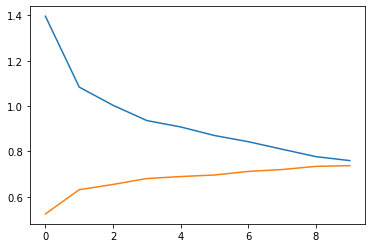

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])